# AWS Spot Price Predictions

## AWS Spot Instances

Amazon EC2 Spot Instances let you take advantage of unused EC2 capacity in the AWS cloud. Spot Instances are available at up to a 90% discount compared to On-Demand prices.

According to Amazon, Spot instances can be used for stateless/fault-tolerant/flexible workloads. The idea it to provide machines for much lower prices while promising no guarantees regarding how long the machine will be available, providing only 60 seconds notice before terminating the machine.





## Goals
The idea is to use the discounts Spot instances provide to minimize the cost of cloud workloads. To achieve that, we want to predict both price changes and upcoming interruptions. Thus providing the workload with enough time to gracefully hand over resources and safely shut down the machine with minimal loss of progress.

So the main 2 goals are:
- Provide predictions for Spot price changes
- Provide predictions for upcoming interruptions



## Data Fetching

For the ML models we needed as much data as possible. Some of the data was provided to us (`spotData.csv`) and some we tried to fetch ourselves.

We created a script `simple_history_log.py` that fetches as much data as possible using the AWS API (called `boto3`). The script concurrently (for different regions) fetches data from the last 3 months (that's all the API can provide) from most recent to oldest. Since the script takes a long time to run, we added a mechanism to save the progress periodically as well as let the script continue where it left off.



### The Fetching Proccess using `boto3`
Since, naturally, there is a lot of data in a span of 3 months, the API returns a single "page" (chunk) of data for each API request. In the response, there's a `next_token` which we need to provide for the next request to get the next chunk of data. Thus, the fetching per region needs to be done in a serial manner.
Each respone is a json in the following format:
```json
{
    'NextToken': '<base64_token>',
    'ResponseMetadata': {/* We don't really care about that */},
    'SpotPriceHistory': [
        /* Timestamped entries. Each entry is for a specific machine, OS and region. It contains the timestamp and the price */
        {
            'AvailabilityZone': 'eu-north-1b',
            'InstanceType': 'r5n.12xlarge',
            'ProductDescription': 'Windows',
            'SpotPrice': '2.928700',
            'Timestamp': datetime.datetime(2022, 3, 9, 20, 35, 8, tzinfo=tzutc())
         },
         ...
    ]
}
```



It is also important to note that it's not 100% clear what is the exact meaning of the data we are fetching. Sometimes we can get big gaps between data points (timestamp wise. For example we might not see any data for an instance between Feb 10th until Feb 12th). 
At first we thought the API only provides a data spot when the price changes but then we noticed there are sometimes very sequential data point with very minimal time gaps (seconds sometimes) with identical prices.



We couldn't find any definite explanation for the phenomenon but here are a few theories that might be worth exploring:
1. The big gaps mean the machine was not available at all as a Spot instance at that time
2. The prices were changing but with such minor changes that the precision isn't fine enough to show it (i.e. the backend sends a data point because it detected a change but after server-side rounding, the data point is identical to the last one)



We found contradicting examples for each of those but we might be missing something.
For example we expected to see a very recent timestamp data point for an available Spot machine (if theory 1 is correct) but we didn't always see that, we noticed at times relatively old data points that are aligned with the current unchanged price.
We didn't explore theory 2 enough to say.



It's also unclear whether or not a data point will be provided when the machine isn't even available. Also, we don't know what is the precision of this data and if it "catches" all of the changes.

Another weird thing was that the `boto3` only **usually** gave us the data point sorted by data. Meaning, sometimes we could get a data point for the 10th then 11th and then 10th again. Although rare, it did happen.

We continued with those unknowns in mind.

### Fetching from Spot Advisor

Amazon provides that shows the last month's averages of savings and interruptions: https://aws.amazon.com/ec2/spot/instance-advisor/

We wanted to watch the webpage for changes over time and from slight changes build finer data. We created a script to watch that page `get_int_json.[py|sh]` but since the data provided by this page is merely rough estimates, the small changes didn't reflect as we hoped.

### Usage of the Fetching Script

As we said, `simple_history_log.py` will use a thread pool to fetch data using the `boto3` api. The script has no parameters exposed to command line. Most of the parameters appear as constants at the beginning of the file.


To run the script you need:
1. python3
2. venv
3. AWS CLI and credentials (see https://docs.aws.amazon.com/cli/latest/userguide/getting-started-prereqs.html)


#### Setup Environment
Make sure you have already set up the AWS on the machine.

Create a `venv`:
```bash
python3 -m venv venv
```

If you're not already within the `venv`, activate it:
```bash
source venv/bin/activate
```

Install pip requirements:

```bash
pip install -r pip_requirements.txt
```

Now you're ready to go.

#### Running

With the `venv` activated:
```bash
python simple_history_log.py
```

The scripts periodically saves the progress so you can interrupt it and continue where you left off (unless you wait too long and the `next_token` is expired).

Note that the script will not save identical adjacent data points.

Also note that the scripts saves the logs to a file called `spot_history_boto3.log`.


### Other Scripts


There are also a few other scripts you can use. Here is a general list of a few of them:
 
- `graphSpotPrice.py` - Will show graphs for the prices over time. takes the data from CSV
- `compress_pickle.py` - Will pickle and compress the json file that the `simple_history_log.py` created (well, actually any other json too)
- `decompress_pickle.py` - Decompress back to json
- `get_int_json[.sh|.py]` - Downloads and deduplicates the the monthly statistical data of interruptions and savings from the spot advisor






## Directions

### NN

### Static Analysis



# Pricing Prediction
We looked for time series forecasting models that could fit for the task of predicting prices. We decided to use Temporal Fusion Transformer, specifically the implementation from the `PyTorch Forecasting` library. We chose that model because it's currently the state of the art for time series forecasting, and allows prediction for multi targets.

We fed the model with the following features:
* Region
* Instance type
* Major & minor of the instance type
* Operating system
* Date
* And of course, the price

The machines are grouped by their region, os and instance type. Meaning, for each of these triplets we want to forecast the price.

We chose the loss to be `QuantileLoss` as it fits to this type of prediction and assesses the performance of the model with the MAE measure (as it's a regression task).

For a baseline, we chose a model that simply predict the previous price as a predictor.

Unfortunately, we found that TFT model performed roughly the same as the baseline, and after furthur examination of the data, we realised that it's due to the fact that the prices are mostly constant. It worth noticing that even on machines that their prices changes from time to time, it happens seldom.

Hence, we took 25% of the machines that their prices are the least constant. Even in this scenario, the baseline model had very simillar predictions to the TFT. We assumed that trying to predict the prices in a fancy way is an over kill, and assuming that the previous price is the next price is a reasonable assumption.


# Interruptions Prediction
The main difficulty was that there's no much data regarding interruptions. The only data AWS provides is [here](https://aws.amazon.com/ec2/spot/instance-advisor/), providing only monthly statistical data about roughly approximated frequency of interruptions.
There isn't data that can help us to predict for a machine how likely it is to be shut down.

Nevertheless, we tried to use this data to find correlations between the interruptions and the other data that is provided there:

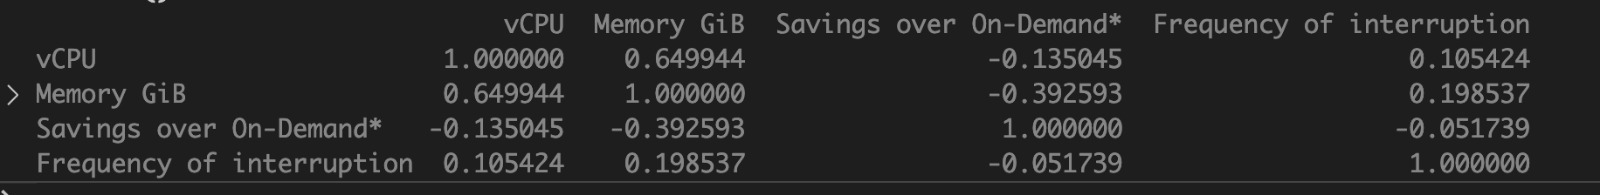

As can see, correlation between the frequency of interruptions to the other data is pretty low, and could not help us to make clear statements.

To further investigate it we download all the available data and ran some classic ML models that try to predict to what category of frequency of interruption each machine belongs to. We used simple models in order to understand how the model decides the interrption frequency.

We used two types of models:
* Linear models - we assume that features with that their corresponding weight is higher is more relevant.
* Trees based models - Trees are naturally explainable, so it's a good choice for our needs.

## Linear models
We explored several linear models (as can be seen in `interruptions.ipynb`). We eventually decided to use `Lasso`, as its use of L1 regularization tend to produce sparse weights vector, hence in some sense explains its decision with fewer features. We fine-tuned the L1 regularization weight that gave us relatively sparse weight vector without sacrifying the accuracy by much.

By sorting the features by the corresponding weights of the trained `Lasso` model we got this result (top 30 features with highest weights):

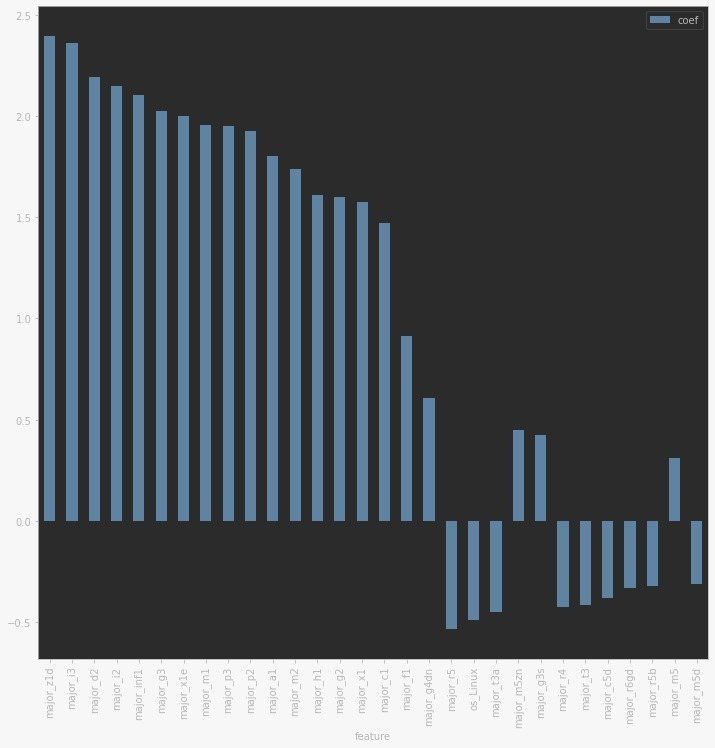

Unfortunately, the chosen features are unique to each machine (the instance type), so in a sense it learns for each machine its own value that way.

Hence, we filtered only the features that describe the regions of the machines to get some insights about the location of machines:

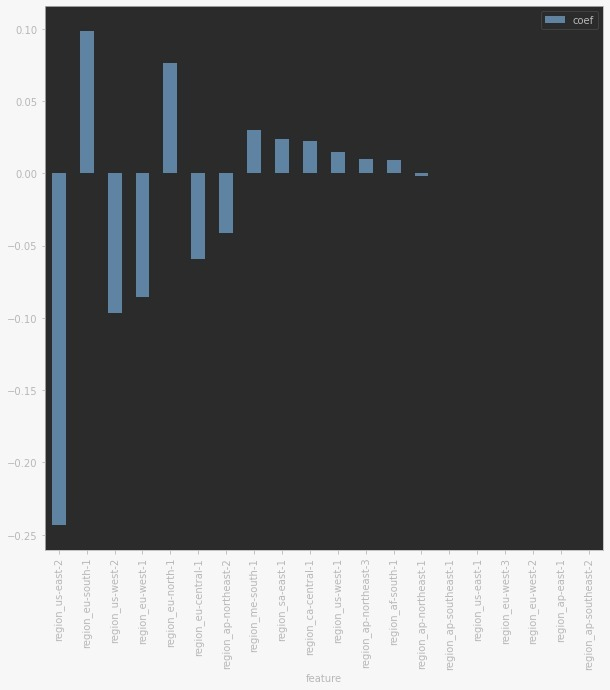

As we can see, some regions tend to have less/more interrptions!
By doing the same for the minor we get:

As we can see, some regions tend to have less/more interrptions!
By doing the same for the minor we get:

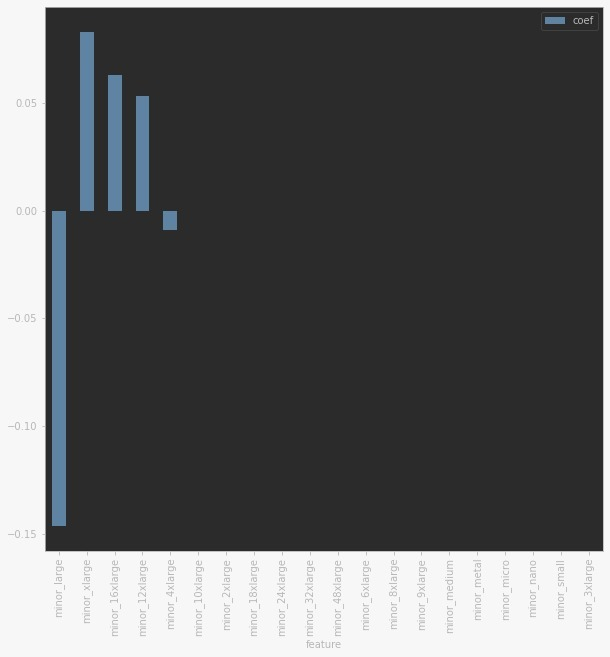

So the `large` minor tend to have less interruptions and some others tend to have more.

Doing the same for the os type gave:

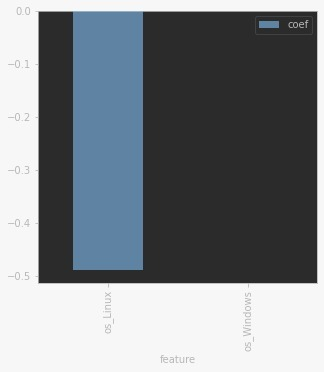

It is clear that linux machines tend to have less interruptions compared to windows machines!

## Tree based models
We decided to use random forest. We took the features importances, calculated by the reduction of entropy that each feature does in the decision trees.
We sorted the fetures by their importances and got this plot:

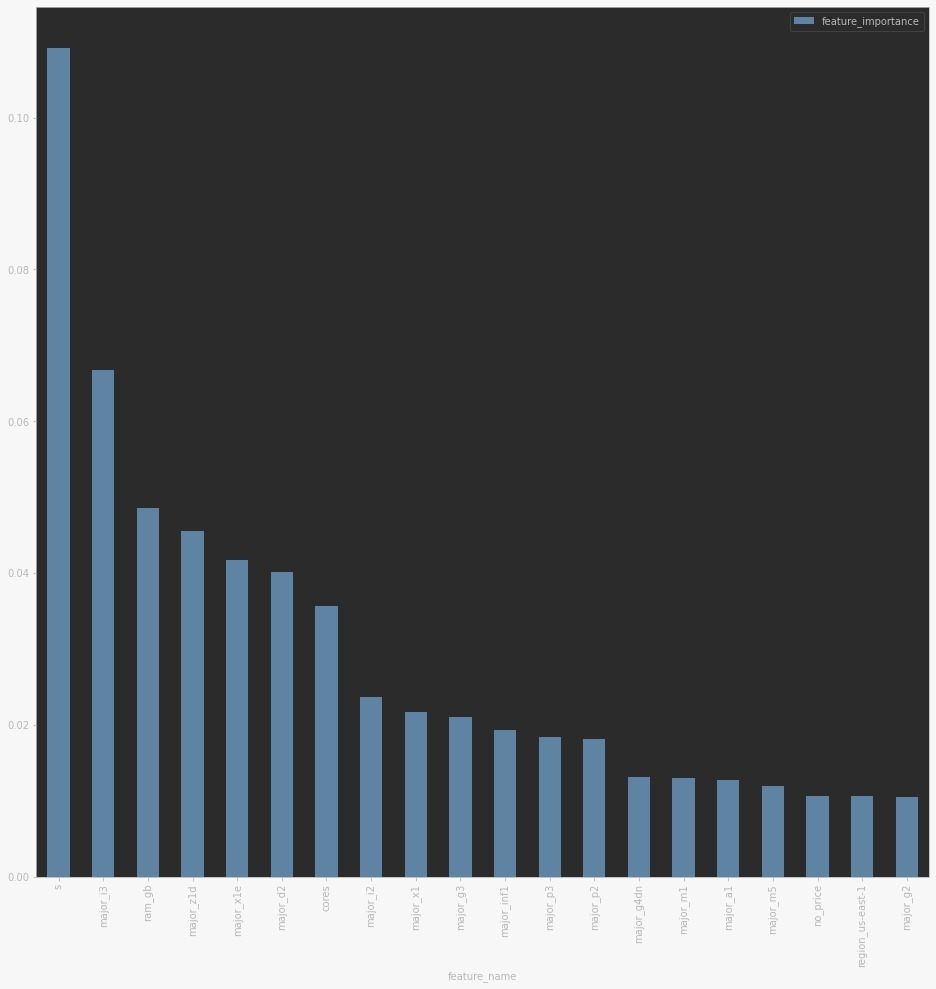

We can see the the most important feature is the savings percentage!

Then, we generated some scatter plots that try to show visual relations between generic features (like savings percentage, amount of ram, number of cores):

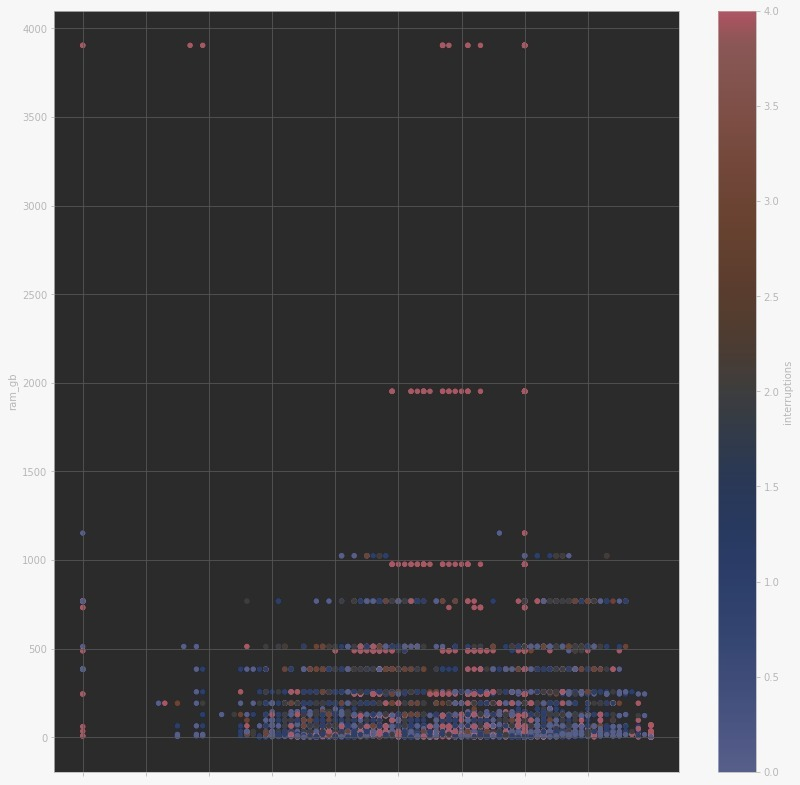

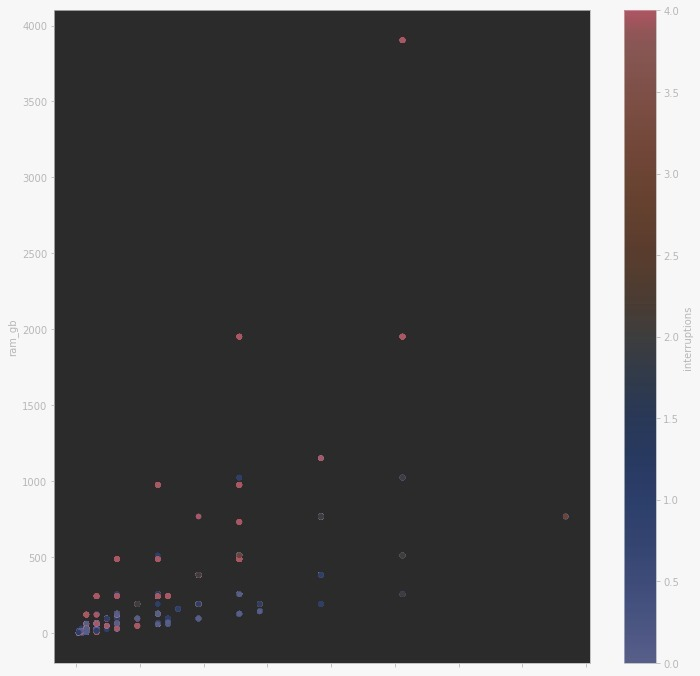

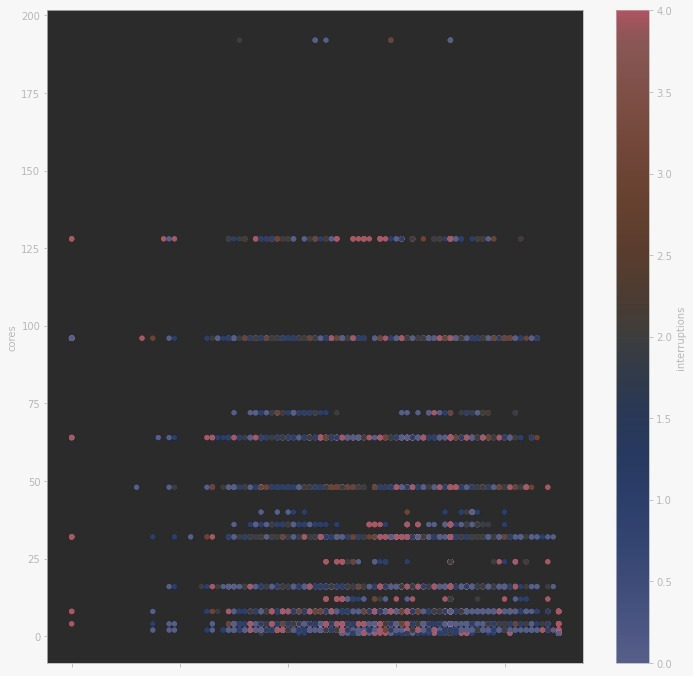

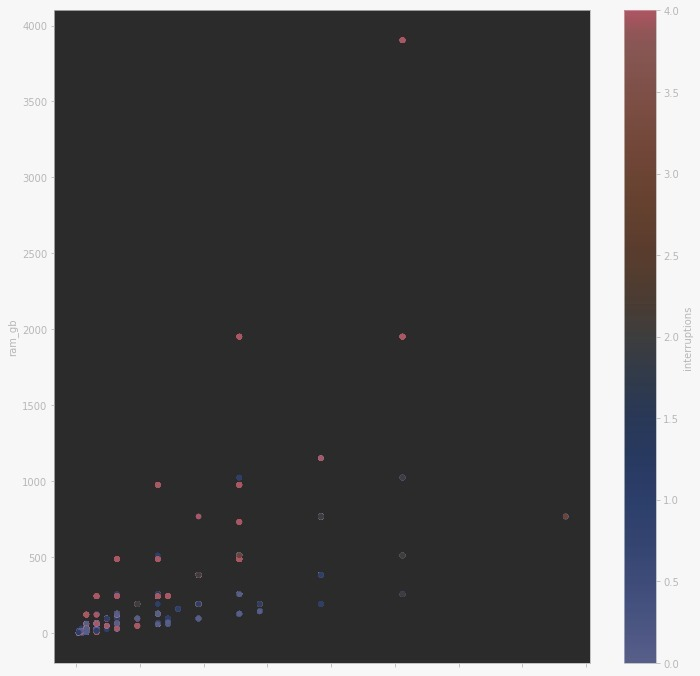

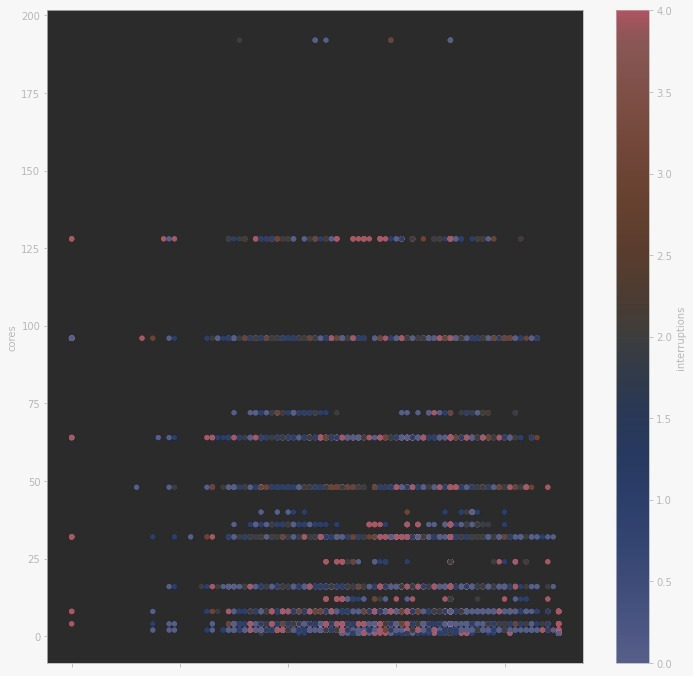

There is no clear pattern that we can visually see from these plots, and it make sense, as the models did not manage to use those features to make useful predictions about the interrptions.

## Conclusion
With different datasets, we tried finding simple correlations between the features without ML as well as more complex relations using ML models.
After taking multiple approaches, we couldn't get a model that gives consistently good results. Especially not better than the [rebalance notice](https://docs.aws.amazon.com/whitepapers/latest/cost-optimization-leveraging-ec2-spot-instances/managing-instance-termination.html) that AWS does try to provide users with in addition to the two minute warning.

We suspect that with a little mode data, it is possible to get good results. We even encountered a few articles that managed to do something similar (companies with access to users' data including interruptions). Contacting the authors bore no fruit.

That being said, it seems that AWS already does a lot to give users transparancy regarding the risk of interruptions. Including features to allow users to create a "fleet" of instances to reduce the chance of interruptions (AWS will choose the least likely machine to be interrupted), warnings when a fleet is at high risk, notices when a specific machine is at an elevated risk and more.

Thus, we think that the next logical step is to explore those features and see how effective they are at giving more advance notice (more than the 2 minutes AWS is promising).